# HEALTHCARE OPTIMIZATION
### Zohair Hashmi

The Washington State Health Ministry would like to optimally upgrade staff or resources in existing facilities across Washington so that they can allocate resources to where they are most needed, based on demand for services in different geographic regions/areas.
To address this problem, the health ministry needs to: <br>

• Make services more accessible by allocating resources to where they are most needed; increasing capacity in some facilities and decreasing capacity in others. <br>
• Minimize people’s travel time so that they only travel to their nearby facility. 

##### INTRODUCTION: 

In the state of Washington we are provided with 5 healthcare facilities in the cities of Bellevue, Seattle, Snohomish, Snoqualmie and Wenatchee. Each of these facility tends to povide healthcare to the population residing nearby. Now, these facilities are either overstaffed or understaffed to serve the population. This tends to raise a concern for people living in areas nearby as they often have to travel to a far off facility to get their healthcare done. <br>
Therefore, to facilitate the patients some of the staff needs to be relocated. There are two things that need to be considered before relocation. <br>
1. Staff to patients ratio should be approximately 1/2808.
2. Relocation needs to be done in a way that people travel to the facility closest to them in terms of travel time.

-----------------------------------------------------------------

In [3]:
# install and import folium to plot maps.
! conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge

Initially we download the database for Washington state that contains the zip codes and their corresponding locations and estimated population for the year 2015. To extract the most recent population data available we can resort to US govt's census api available, but given that unitedstateszipcodes.com returns a complete dataset for the population in 2015 (for each respective zip code), I will use this data instead of the extracting data from US govt's census api that is incomplete. <br>
To download zip codes and location information we use database available on https://www.unitedstateszipcodes.org/zip-code-database/


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The following code uploads the database and converts it into a dataframe using pandas.

In [2]:
df = pd.read_csv('zip_code_database.csv')
df.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


Since, we are already provided with the zipcodes for the facility areas, we can use these to return the city names for each zip code. <br>

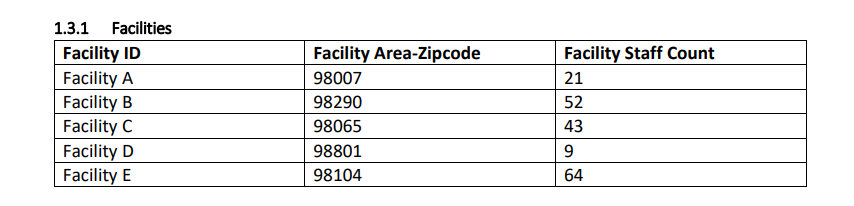

In [3]:
from IPython.core.display import Image, display
display(Image('table.png', width=1900, unconfined=False))

In [4]:
# ZIPCODE API
zipcodes = [98007,98290,98065,98801,98104]
cities = []
for z in range(len(zipcodes)):
    cities.append(df[df['zip']==zipcodes[z]]['primary_city'].values.tolist())
cities = [cities[0][0],cities[1][0],cities[2][0],cities[3][0],cities[4][0]]
cities

['Bellevue', 'Snohomish', 'Snoqualmie', 'Wenatchee', 'Seattle']

Now, we need to extract the zip codes located in each city in order to identify the areas nearby, the populations of which use the health-care facilities available in zones A-E.

In [5]:
areas = []
df_areas = pd.DataFrame()
df_areas = df[df['primary_city'] == cities[0]]
df_areas = df_areas.append(df[df['primary_city'] == cities[1]])
df_areas = df_areas.append(df[df['primary_city'] == cities[2]])
df_areas = df_areas.append(df[df['primary_city'] == cities[3]])
df_areas = df_areas.append(df[df['primary_city'] == cities[4]])
df_areas = df_areas.rename(columns = {'irs_estimated_population_2015':'population_15'})
df_areas = df_areas[df_areas['state']=='WA']
print(df_areas.shape)

#removing unnecessary columns from the dataframe
df_areas = df_areas.reset_index()
df_areas = df_areas.drop(columns=['decommissioned','acceptable_cities','unacceptable_cities','county','timezone','area_codes','world_region','country','type','index'])

print(df_areas.head())
print(df_areas.shape)

(77, 15)
     zip primary_city state  latitude  longitude  population_15
0  98004     Bellevue    WA     47.61    -122.21          31250
1  98005     Bellevue    WA     47.62    -122.16          18860
2  98006     Bellevue    WA     47.55    -122.14          39630
3  98007     Bellevue    WA     47.62    -122.14          26280
4  98008     Bellevue    WA     47.60    -122.11          25120
(77, 6)


We will use the data from the dataframe above to derive a dataframe tabulating only the zip codes having the five facilities.

In [6]:
facility = []
df_facility = pd.DataFrame()
for z in range(len(zipcodes)):
    df_facility = df_facility.append(df_areas[df_areas['zip'] == zipcodes[z]])

df_facility = df_facility.reset_index().drop(columns=['population_15','index'])
df_facility['staff_count'] = [21,52,43,9,64]
print(df_facility)

     zip primary_city state  latitude  longitude  staff_count
0  98007     Bellevue    WA     47.62    -122.14           21
1  98290    Snohomish    WA     47.94    -122.00           52
2  98065   Snoqualmie    WA     47.53    -121.80           43
3  98801    Wenatchee    WA     47.37    -120.35            9
4  98104      Seattle    WA     47.60    -122.32           64


In [7]:
#converting latitudes and longitudes into lists in order to plot on a folium map

latitudes = df_areas['latitude'].values.tolist()
longitudes = df_areas['longitude'].values.tolist()

fac_lat = df_facility['latitude'].values.tolist()
fac_lng = df_facility['longitude'].values.tolist()

### Visualizing the map

In [17]:
# ---------- plot map

#define the world map
world_map = folium.Map()

# define the world map centered around Washington with a higher zoom level
washington_map = folium.Map(location=[47.6062, -122.3321], zoom_start=8)

for lat, lng in zip(latitudes, longitudes):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='blue')
    ).add_to(washington_map)

for lat, lng in zip(fac_lat, fac_lng):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='red')
    ).add_to(washington_map)

# display world map
washington_map

### Travel time extraction using HERE api

HERE API easisly provides travel time difference between two points, which is an important metric for us. We need to provide origin and destination coordinates to our requested url of HERE's Routing API.
<\n> In the following code:
 - fac_lat and fac_lng are facility coordinates, converted into strings and used as destination coordinates for calculating travel time.
 - latitudes and longitudes are nearby area coordinates, converted into strings and used as origin coordinates for calculating travel time.


In [9]:
#extracting travel time between each locality and all the 5 respective facilities (A-E)

duration = []
dest_lat = list(map(str,fac_lat))
dest_lng = list(map(str,fac_lng))
org_lat = list(map(str,latitudes))
org_lng = list(map(str,longitudes))

for d_lat,d_lng in zip(dest_lat,dest_lng):
    traveltime = []
    for o_lat,o_lng in zip(org_lat,org_lng):
        url = 'https://route.api.here.com/routing/7.2/calculateroute.json?app_id=H3h4oogZ3viIMirIDaoC&app_code=ubnLgHI_DnlRppv-jeaWag&waypoint0=geo!' + d_lat +',' + d_lng +'&waypoint1=geo!' + o_lat + ',' + o_lng + '&mode=fastest;car;traffic:disabled'
        r = requests.get(url)
        traveltime.append(r.json()['response']['route'][0]['summary']['travelTime'])
    duration.append(traveltime)
        
print(duration)

[[817, 331, 1211, 0, 543, 688, 688, 2694, 2390, 1766, 2031, 9812, 10927, 1139, 1048, 1268, 1255, 1145, 1942, 1672, 1562, 1140, 1139, 1322, 1139, 1351, 1468, 1853, 1716, 1807, 1439, 1270, 1344, 1427, 1434, 1699, 1139, 1139, 1565, 1565, 1544, 1427, 2009, 1584, 1139, 1139, 1216, 1048, 2096, 1869, 1251, 1139, 1792, 1927, 1950, 1251, 1139, 1139, 2086, 1794, 1139, 1251, 1438, 1139, 1901, 1632, 1139, 1251, 1145, 1719, 1717, 1669, 1139, 1139, 1048, 2103, 1844], [2758, 2773, 3163, 2789, 3063, 2637, 2637, 0, 698, 1479, 3895, 9530, 10645, 3066, 2970, 2858, 3244, 3067, 3861, 3287, 3481, 3031, 3066, 3244, 3066, 3340, 3094, 3772, 3172, 3728, 3330, 3161, 3266, 3350, 2845, 3618, 3066, 3066, 3521, 3521, 2577, 3350, 3928, 3540, 3066, 3066, 3205, 2970, 4052, 3825, 3178, 3066, 2573, 3883, 2787, 3178, 3066, 3066, 4042, 3750, 3066, 3178, 3369, 3066, 2967, 3588, 3066, 3178, 3067, 3675, 3673, 3612, 3066, 3066, 2970, 4059, 3735], [2073, 2089, 1970, 1955, 1752, 1930, 1930, 3879, 3800, 3176, 0, 8921, 10036, 2264

Let's save the travel time durations obtained into a csv file.

In [10]:
import csv

with open('duration_data.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL, delimiter=',')
    wr.writerow(duration)

- Now, we can merge the two dataframes (df_areas & df_time) into a single dataframe.
- HERE API returns travel time in seconds so it needs to be converted into hours for better relatabillity of this metric. We divide each of the column A B C D and E with 3600, since one hour has 3600 seconds.

In [11]:
df_time = pd.DataFrame(duration)
df_time = df_time.transpose()
df_time = df_time.rename(columns={0:'A',1:'B',2:'C',3:'D',4:'E'})
df_data = df_areas.join(df_time)

#change seconds into hours
df_data.update(df_data['A']/3600)
df_data.update(df_data['B']/3600)
df_data.update(df_data['C']/3600)
df_data.update(df_data['D']/3600)
df_data.update(df_data['E']/3600)

#use 60 % of population count only
df_data.update(df_data['population_15']*0.6)

df_data.head()

,zip,primary_city,state,latitude,longitude,population_15,A,B,C,D,E
0,98004,Bellevue,WA,47.61,-122.21,18750.0,0.226944,0.766111,0.575833,2.755556,0.313333
1,98005,Bellevue,WA,47.62,-122.16,11316.0,0.091944,0.770278,0.580278,2.760000,0.346389
2,98006,Bellevue,WA,47.55,-122.14,23778.0,0.336389,0.878611,0.547222,2.726944,0.368056
3,98007,Bellevue,WA,47.62,-122.14,15768.0,0.000000,0.774722,0.543056,2.722778,0.338611
4,98008,Bellevue,WA,47.60,-122.11,15072.0,0.150833,0.850833,0.486667,2.666389,0.342778


Let's label each location to it's closest facility where the population of that location would prefer to head to in case of a healthcare need.

In [12]:

df_data['closest_facility']=''
for i in range(len(df_data)):
    least = min(df_data.loc[i]['A'],df_data.loc[i]['B'],df_data.loc[i]['C'],df_data.loc[i]['D'],df_data.loc[i]['E'])
    if df_data['A'][i] == least:
        df_data['closest_facility'][i] = 'A'
    elif df_data['B'][i] == least:
        df_data['closest_facility'][i] = 'B'
    elif df_data['C'][i] == least:
        df_data['closest_facility'][i] = 'C'
    elif df_data['D'][i] == least:
        df_data['closest_facility'][i] = 'D'
    elif df_data['E'][i] == least:
        df_data['closest_facility'][i] = 'E'

df_data.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__'

,zip,primary_city,state,latitude,longitude,population_15,A,B,C,D,E,closest_facility
0,98004,Bellevue,WA,47.61,-122.21,18750.0,0.226944,0.766111,0.575833,2.755556,0.313333,A
1,98005,Bellevue,WA,47.62,-122.16,11316.0,0.091944,0.770278,0.580278,2.760000,0.346389,A
2,98006,Bellevue,WA,47.55,-122.14,23778.0,0.336389,0.878611,0.547222,2.726944,0.368056,A
3,98007,Bellevue,WA,47.62,-122.14,15768.0,0.000000,0.774722,0.543056,2.722778,0.338611,A
4,98008,Bellevue,WA,47.60,-122.11,15072.0,0.150833,0.850833,0.486667,2.666389,0.342778,A
5,98009,Bellevue,WA,47.61,-122.20,839.4,0.191111,0.732500,0.536111,2.715833,0.286111,A
6,98015,Bellevue,WA,47.61,-122.20,531.6,0.191111,0.732500,0.536111,2.715833,0.286111,A
7,98290,Snohomish,WA,47.94,-122.00,19050.0,0.748333,0.000000,1.077500,2.640000,0.910556,B
8,98291,Snohomish,WA,47.92,-122.09,1153.8,0.663889,0.193889,1.055556,2.654167,0.813056,B
9,98296,Snohomish,WA,47.85,-122.09,15336.0,0.490556,0.410833,0.882222,2.633611,0.647778,B


Saving the dataset obtained to a .csv file.

In [13]:
df_data.to_csv('nearby_areas_data.csv')

### Plotting classification of areas nearby

Now that we have assigned each location a label (a class), i.e A-E, we can create a lists of the coordinates of each location availing a particular facility. These coordinates can then be used to plot a map using folium that reflects the distribution of clusters. 

In [14]:
cord_A = (df_data[df_data['closest_facility'] == 'A']['latitude'].values.tolist(),df_data[df_data['closest_facility'] == 'A']['longitude'].values.tolist())
cord_B = (df_data[df_data['closest_facility'] == 'B']['latitude'].values.tolist(),df_data[df_data['closest_facility'] == 'B']['longitude'].values.tolist())
cord_C = (df_data[df_data['closest_facility'] == 'C']['latitude'].values.tolist(),df_data[df_data['closest_facility'] == 'C']['longitude'].values.tolist())
cord_D = (df_data[df_data['closest_facility'] == 'D']['latitude'].values.tolist(),df_data[df_data['closest_facility'] == 'D']['longitude'].values.tolist())
cord_E = (df_data[df_data['closest_facility'] == 'E']['latitude'].values.tolist(),df_data[df_data['closest_facility'] == 'E']['longitude'].values.tolist())


In the following map, each pointer denotes a zip code location and their colors identify what facility is close to them.

In [ ]:
cluster_map = folium.Map(location=[47.6062, -122.3321], zoom_start=8)

for lat, lng in zip(cord_A[0], cord_A[1]):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='blue')
    ).add_to(cluster_map)

for lat, lng in zip(cord_B[0], cord_B[1]):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='green')
    ).add_to(cluster_map)
    
for lat, lng in zip(cord_C[0], cord_C[1]):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='black')
    ).add_to(cluster_map)
    
for lat, lng in zip(cord_D[0], cord_D[1]):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='pink')
    ).add_to(cluster_map)
    
for lat, lng in zip(cord_E[0], cord_E[1]):
    folium.Marker(
        location = [lat, lng],
        icon=folium.Icon(color='red')
    ).add_to(cluster_map)
    
# display world map
cluster_map

In order to make use of the clustered data, we should sum the population of the locations that are associated with a single facility.

In [15]:
# sum of population utlising each facility
pop_list =[]
pop_list.append(df_data['population_15'].where(df_data['closest_facility'] == 'A').fillna(0).sum())
pop_list.append(df_data['population_15'].where(df_data['closest_facility'] == 'B').fillna(0).sum())
pop_list.append(df_data['population_15'].where(df_data['closest_facility'] == 'C').fillna(0).sum())
pop_list.append(df_data['population_15'].where(df_data['closest_facility'] == 'D').fillna(0).sum())
pop_list.append(df_data['population_15'].where(df_data['closest_facility'] == 'E').fillna(0).sum())
pop_list

[86055.0, 35539.8, 9150.0, 25791.0, 497286.0]

As given in the task, the ratio needs to be 2808 patients to 1 staff member. Therefore, let's calculate the ratios for each facility.

In [16]:
df_facility['est_patients'] = pop_list
df_facility['ratio'] = df_facility['est_patients'] /df_facility['staff_count']
df_facility

,zip,primary_city,state,latitude,longitude,staff_count,est_patients,ratio
0,98007,Bellevue,WA,47.62,-122.14,21,86055.0,4097.857143
1,98290,Snohomish,WA,47.94,-122.00,52,35539.8,683.457692
2,98065,Snoqualmie,WA,47.53,-121.80,43,9150.0,212.790698
3,98801,Wenatchee,WA,47.37,-120.35,9,25791.0,2865.666667
4,98104,Seattle,WA,47.60,-122.32,64,497286.0,7770.093750


We can plot the staff to population graph to visualize the distribution of staff members

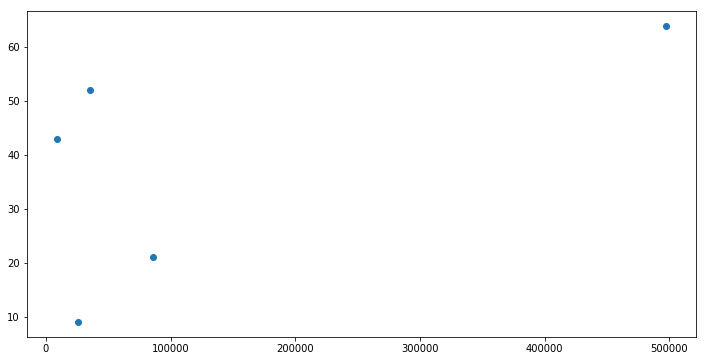

In [48]:
import matplotlib.pyplot as plt
df_facility.sort_values(by = ['est_patients'], inplace= True)

x = df_facility['est_patients'].values.tolist()
y = df_facility['staff_count'].values.tolist()

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(x, y)

In order to suggest the relocation of the staff members we need to develop an approach where we keep the ratio as close as possible and keep in mind the travel time duration for people living nearby.<br>

The problem for travel time duration is handled when clustering the locations on basis of the minimum time it takes to travel to any facility.<br>

In case the ministry is looking for relocations only, the staff allocation would be suggested as following.

In [17]:
k = pd.DataFrame()
i = 2808

while sum(round(df_facility['est_patients']/i)) >= sum(df_facility['staff_count']):
    if sum(round(df_facility['est_patients']/i)) == sum(df_facility['staff_count'].astype(float)):
        k = round(df_facility['est_patients']/i)    
    i = i+10

df_facility['suggested_staff_count'] = k.astype(int)

In [18]:
df_facility

,zip,primary_city,state,latitude,longitude,staff_count,est_patients,ratio,suggested_staff_count
0,98007,Bellevue,WA,47.62,-122.14,21,86055.0,4097.857143,25
1,98290,Snohomish,WA,47.94,-122.00,52,35539.8,683.457692,10
2,98065,Snoqualmie,WA,47.53,-121.80,43,9150.0,212.790698,3
3,98801,Wenatchee,WA,47.37,-120.35,9,25791.0,2865.666667,7
4,98104,Seattle,WA,47.60,-122.32,64,497286.0,7770.093750,144


However, since the ministry is looking for upgrading and relocating staff according to the needs of the facilities, we can conclude the following table as a suitable suggestion.

In [21]:
j = round(df_facility['est_patients']/2880)
df_facility['suggested_staff_count'] = j.astype(int)
df_facility

,zip,primary_city,state,latitude,longitude,staff_count,est_patients,ratio,suggested_staff_count
0,98007,Bellevue,WA,47.62,-122.14,21,86055.0,4097.857143,30
1,98290,Snohomish,WA,47.94,-122.00,52,35539.8,683.457692,12
2,98065,Snoqualmie,WA,47.53,-121.80,43,9150.0,212.790698,3
3,98801,Wenatchee,WA,47.37,-120.35,9,25791.0,2865.666667,9
4,98104,Seattle,WA,47.60,-122.32,64,497286.0,7770.093750,173


-------------------------------------------------------------

### CONCLUSION
<br>
In order to facilitate the population living the five cities of Washington state, we need to make slight changes to the staff counts in each facility. We will have to move staff from Snohomish, Snoqualmie and Wenatchee (overstaffed facilities) to Seattle and Bellevue (understaffed facilities).
<br>
This way we can maintain that people living nearby will not have to go to healthcare facilities in far off locations, just because the ones nearby are understaffed. 